In [1]:
import datetime 
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
%matplotlib inline

In [90]:
# read the data
cars = pd.read_csv("autos.csv", encoding="Latin1", parse_dates = ['dateCrawled','dateCreated','lastSeen'])

In [119]:
# clean the data:
# only these values make sense for car age:
cars = cars[(cars.yearOfRegistration < 2017) & (cars.yearOfRegistration > 1900)]
# we don't want to have non-sensible prices:
cars = cars[(cars.price < 500000) & (cars.price > 500)]
# only interested in working cars for now:
cars = cars[cars.notRepairedDamage != "ja"]

In [66]:
cars = cars.assign(mileage_cat=[("low", "medium", "med-high", "high")[min(3, int(math.floor(x/50000)))] for x in cars.kilometer])

In [104]:
# age is a better feature than year of registration
# here we use the number of days since registration
cars = cars.assign(age=[datetime.timedelta(seconds=(x.dateCreated.timestamp() - 
                        (datetime.datetime.strptime(
                            str(x.yearOfRegistration) + str(x.monthOfRegistration), "%Y%M")).timestamp())).days
                        for i, x in cars.iterrows()])

In [109]:
# only use cars not registered in the future
cars = cars[cars.age > 0]

In [97]:
secs = datetime.timedelta(seconds=12)

In [102]:
secs.days

0

In [108]:
cars[cars.age<0]

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,...,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen,age
22,2016-03-23 14:52:51,Opel_Meriva_1.Hand_TÜV_3.2018,privat,Angebot,2900,test,NaN,2018,manuell,90,...,150000,5,benzin,opel,nein,2016-03-23,0,49716,2016-03-31 01:16:33,-650
26,2016-03-10 19:38:18,Citroen_C4_Grand_Picasso.,privat,Angebot,5555,control,NaN,2017,manuell,125,...,125000,4,NaN,citroen,nein,2016-03-10,0,31139,2016-03-16 09:16:46,-298
48,2016-03-25 14:40:12,VW_Golf_6___Klima___Alu___Scheckheft_!!!,privat,Angebot,7750,control,NaN,2017,manuell,80,...,100000,1,benzin,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44,-283
51,2016-03-07 18:57:08,Fiat_punto_5_tuerer__6_gang,privat,Angebot,2000,control,NaN,2017,manuell,90,...,150000,11,diesel,fiat,ja,2016-03-07,0,66115,2016-03-07 18:57:08,-301
58,2016-03-10 20:53:19,Seat_inca_1.9SDI___LKW_Zulassung___TÜV_NEU,privat,Angebot,2399,test,NaN,2018,manuell,64,...,125000,3,NaN,seat,nein,2016-03-10,0,33397,2016-03-25 10:17:37,-663
66,2016-03-28 17:41:27,Opel_Astra_1.4_mit_vielen_Extras!!!!,privat,Angebot,10900,test,NaN,2017,manuell,101,...,50000,3,NaN,opel,nein,2016-03-28,0,63607,2016-04-06 23:15:52,-280
115,2016-03-19 18:40:12,Golf_IV_1.4_16V,privat,Angebot,0,test,NaN,2017,manuell,0,...,5000,12,benzin,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05,-289
160,2016-03-09 12:53:53,KIA_SPORTAGE,privat,Angebot,14500,control,NaN,2017,manuell,136,...,125000,5,diesel,kia,nein,2016-03-09,0,49696,2016-04-05 23:45:15,-299
168,2016-04-04 12:57:02,OPEL_astra_G_TÜV_NEU,privat,Angebot,1200,control,NaN,2018,manuell,75,...,150000,0,NaN,opel,nein,2016-04-04,0,15344,2016-04-06 14:45:26,-638
202,2016-03-24 13:51:03,Renault_Twingo_Lazuli_sport_1.2_16V_TÜV_2_jahre,privat,Angebot,2800,control,NaN,2018,manuell,75,...,125000,12,NaN,renault,nein,2016-03-24,0,86199,2016-04-07 05:17:27,-649


In [7]:
cars.offerType.value_counts()

Angebot    371516
Gesuch         12
Name: offerType, dtype: int64

(0, 50000)

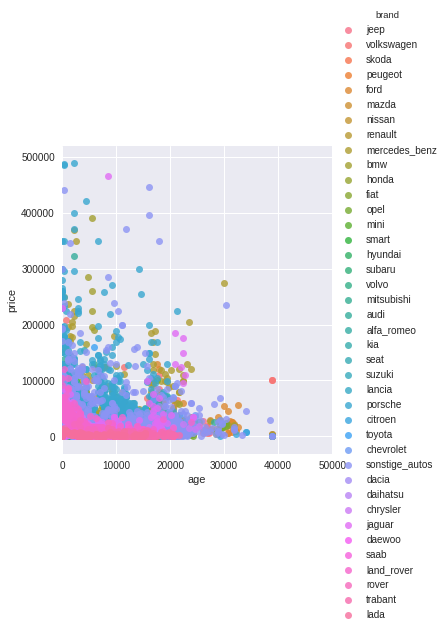

In [120]:
#cars.plot(x="yearOfRegistration", y="price", kind="scatter", ylim=(0, 1000000))
plt.figure()
sns.lmplot('age', 'price', data=cars, fit_reg=False, hue="brand")
plt.xlim(0, 50000)

In [37]:
# most common models
cars.model.value_counts()[:20]

golf           25088
andere         23011
3er            18526
polo            9744
a4              9407
passat          9232
corsa           8964
astra           8784
c_klasse        8260
5er             8074
e_klasse        7137
a3              6036
a6              5657
focus           5172
transporter     5148
2_reihe         4416
fiesta          4327
fortwo          4090
a_klasse        3814
1er             3696
Name: model, dtype: int64

In [46]:
# get general depreciation
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(cars.loc[:, ("kilometer", "yearOfRegistration")], y=cars.price)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
clf.coef_

array([ -8.10373297e-02,   2.49144470e+02])

In [ ]:
# compare depreciation per model

In [14]:
?cars.plot

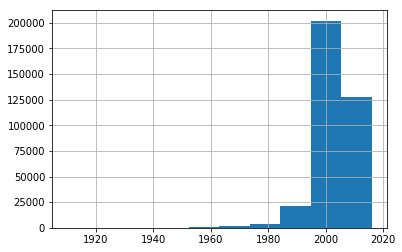

In [23]:
cars.yearOfRegistration.hist()

In [41]:
cars.loc[:, ("price", "model", "yearOfRegistration")]

,price,model,yearOfRegistration
1,18300,NaN,2011
2,9800,grand,2004
3,1500,golf,2001
4,3600,fabia,2008
5,650,3er,1995
6,2200,2_reihe,2004
8,14500,c_max,2014
9,999,golf,1998
10,2000,3_reihe,2004
11,2799,passat,2005


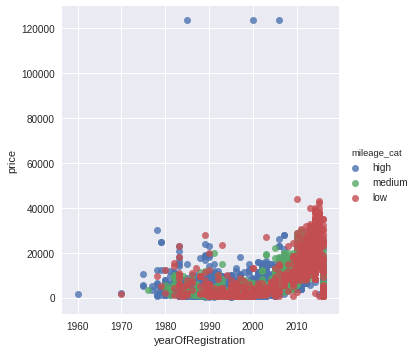

In [58]:

sns.lmplot('yearOfRegistration', 'price', data=cars[cars.model=="golf"], fit_reg=False, hue="mileage_cat")

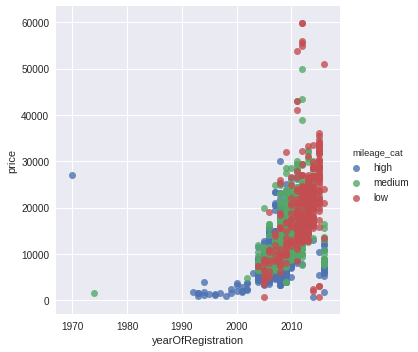

In [63]:

sns.lmplot('yearOfRegistration', 'price', data=cars[cars.model=="1er"], fit_reg=False, hue="mileage_cat")

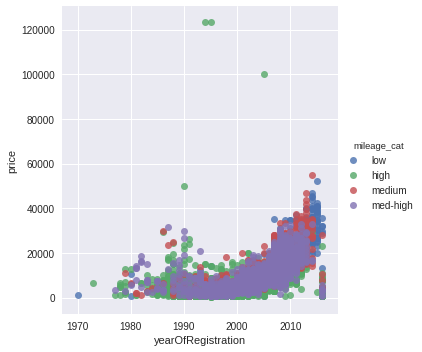

In [68]:
sns.lmplot('yearOfRegistration', 'price', data=cars[cars.model=="3er"], fit_reg=False, hue="mileage_cat")

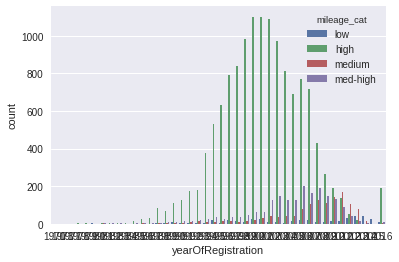

In [67]:
sns.countplot(x="yearOfRegistration", hue="mileage_cat", data=cars[cars.model=="3er"])

In [69]:
# write function for fit parameters for one model
# run function for all models > 100 entries
# test accuracy for each
# see how good my accuracy is, maybe also depending on input data

In [227]:
def randomize(x, y, length):
    random_indices = list(range(length))
    random.shuffle(random_indices)
    x = x[random_indices]
    y = y[random_indices]
    return x, y


def calc_cost_grad(x, y, theta):
    pass


def cost(x, y, theta, lamb=0):
    m = x.shape[0]  # number of training examples
    h = np.dot(x, theta)  # predicted y values
    theta[0] = 0  # theta_0 does not count for regularization
    j = np.sum(((h - y) ** 2))/(2*m) + (lamb/(2*m)) * sum(theta**2)
    return j
    

def normal_equation(train_x, train_y, lamb):
    # normal equation
    import pdb; pdb.set_trace()
    reg = np.zeros((train_x.shape[1], train_x.shape[1]))
    np.fill_diagonal(reg, 1)
    reg[0, 0] = 0
    reg = lamb * reg
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(train_x.T, train_x) + reg),
                          train_x.T), train_y)
    return theta


def train_parameters(train_x, train_y, cv_x, cv_y):
    # choose lambda
    lambdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    train_errors, cv_errors = [], []
    train = normal_equation if train_x.shape[1] < 1000 else gradient_descent
    for lamb in lambdas:
        theta = train(train_x, train_y, lamb)
        train_error = cost(train_x, train_y, theta)
        train_errors.append(train_error)
        cv_error = cost(cv_x, cv_y, theta)
        cv_errors.append(cv_error)
    print(train_errors)
    print(cv_errors)
    import pdb; pdb.set_trace()
    

def scale(x):
    mu = x.sum(axis=0) / x.shape[0]
    s = x.max(axis=0) - x.min(axis=0)
    x = (x - mu)/s
    
    


def fit_params(x, y):
    """Fit a linear regression to predict response vector y from feature matrix x.
    """
    x, y = x.as_matrix(), y.as_matrix()
    # feature scaling
    x, mu, s = scale(x)
    # first: randomize order
    len_x, len_y = x.shape[0], y.shape[0]
    x = np.insert(x, 0, 1, axis=1)
    if len_x != len_y:
        raise "Error: features x and response y have different lengths"
    x, y = randomize(x, y, len_x)
    # second: separate into training, cv, and test set
    div1, div2 = math.floor(len_x * 0.6), math.floor(len_x * 0.8)
    train_x, train_y = x[:div1], y[:div1]
    cv_x, cv_y = x[div1:div2], y[div1:div2]
    test_x, test_y = x[div2:], y[div2:]
    theta = train_parameters(train_x, train_y, cv_x, cv_y)


In [71]:
cars.ndim

2

In [72]:
math.floor(0.1)

0

In [228]:
fit_params(cars[cars.model=="3er"].loc[:, ("kilometer", "age")], cars.price[cars.model=="3er"])

> <ipython-input-227-be0976cba8a6>(24)normal_equation()
-> reg = np.zeros((train_x.shape[1], train_x.shape[1]))
(Pdb) 
(Pdb) c
> <ipython-input-227-be0976cba8a6>(24)normal_equation()
-> reg = np.zeros((train_x.shape[1], train_x.shape[1]))
(Pdb) c
> <ipython-input-227-be0976cba8a6>(24)normal_equation()
-> reg = np.zeros((train_x.shape[1], train_x.shape[1]))
(Pdb) c
[10229004.845534557, 10229004.84553487, 10229035.748918716]
[343403091.13755095, 343403066.01729059, 343154111.77557796]
--Return--
> <ipython-input-227-be0976cba8a6>(47)train_parameters()->None
-> import pdb; pdb.set_trace()
(Pdb) quit


BdbQuit: 

In [191]:
np.array([[1, 0.1], [0.01, 1]]) ** 2

array([[  1.00000000e+00,   1.00000000e-02],
       [  1.00000000e-04,   1.00000000e+00]])

In [141]:
randrange(12)

5

In [153]:
a = cars.head().as_matrix()

In [182]:
a[0, 0] = 0

In [3]:
a = np.ones((4, 10))

In [4]:
a

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [15]:
s = np.array([1,2,3,4,5,6,7,8,9,0])

In [16]:
a - s

array([[ 0., -1., -2., -3., -4., -5., -6., -7., -8.,  1.],
       [ 0., -1., -2., -3., -4., -5., -6., -7., -8.,  1.],
       [ 0., -1., -2., -3., -4., -5., -6., -7., -8.,  1.],
       [ 0., -1., -2., -3., -4., -5., -6., -7., -8.,  1.]])